In [14]:
import numpy as np
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_validate, cross_val_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from pprint import pprint


# Regresión

In [15]:
# Carga de datos

# data = np.load('')
# x = data[:,:-1]
# y = data[:,-1]


# data = load_iris()
# x = data.data
# y = data.target


data = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv")
data.dropna(inplace=True)

x = np.asarray(data[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asarray(data['CO2EMISSIONS'])

In [16]:
# Separación de datos en entrenamiento y test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalización de datos y estandarización de datos

std_scaling = preprocessing.StandardScaler()

x_train = std_scaling.fit_transform(x_train)
x_test = std_scaling.transform(x_test)



# from sklearn.feature_selection import SelectPercentile, mutual_info_classif

# feature_select = SelectPercentile(mutual_info_classif, percentile=90)
# X_train = feature_select.fit_transform(X_train, y_train)
# X_test = feature_select.transform(X_test)

In [17]:
# Algoritmos Regresión
algs = {'OLS':LinearRegression(),
        'Lasso':Lasso(random_state=42), #alpha
        'Ridge':Ridge(random_state=42), #alpha
        'KNN':KNeighborsRegressor(), #n_neighbors, weights, metric
        'ElasticNet':ElasticNet(random_state=42) #alpha, l1_ratio
        }

parameters = {'OLS':{},
              'Lasso':{'alpha':(0.1,0.5,1,10,50,100)},
              'Ridge':{'alpha':(0.1,0.5,1,10,50,100)},
              'KNN':{'n_neighbors':np.arange(1,15),
                     'weights':('uniform','distance'),
                     'metric':('euclidean','manhattan','cosine')
                     },
              'ElasticNet':{'alpha':(0.01,0.1,0.5,1,10,100),
                            'l1_ratio':(0.1,0.25,0.5,0.75,0.9)
                            }
              }

# Métricas Regresión

metricas = {
  'MAE': 'neg_mean_absolute_error',
  'MSE': 'neg_mean_squared_error',
  'R2' : 'r2',
  'RMSE': metrics.make_scorer(lambda y, y_pred:
                      sqrt(metrics.mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': metrics.make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False)}

In [18]:
# results_clas = cross_validate(algs['OLS'], x_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)
# pprint(results_clas)

# Validación cruzada (Sacando media y desviación estandar de los resultados de cada iteración del KFold)
results = {}
for name in algs.keys():
    results[name] = cross_validate(algs[name], x_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)

for name, result in results.items():
    print(f'\nAlgorithm {name}')
    for metrica in metricas:
        print(f'{metrica}: {np.mean(result["test_"+metrica]):.4f} +/- {np.std(result["test_"+metrica]):.4f}')
        # print(f'{result["test_"+metrica]}\n')


Algorithm OLS
MAE: -17.0672 +/- 0.8070
MSE: -559.3836 +/- 32.7867
R2: 0.8572 +/- 0.0138
RMSE: -23.6410 +/- 0.6962
MAPE: -6.5958 +/- 0.3089

Algorithm Lasso
MAE: -17.1413 +/- 0.8867
MSE: -560.6503 +/- 35.7738
R2: 0.8570 +/- 0.0125
RMSE: -23.6660 +/- 0.7553
MAPE: -6.6474 +/- 0.3403

Algorithm Ridge
MAE: -17.0758 +/- 0.8090
MSE: -559.3557 +/- 32.8505
R2: 0.8572 +/- 0.0138
RMSE: -23.6404 +/- 0.6973
MAPE: -6.6007 +/- 0.3099

Algorithm KNN
MAE: -6.3295 +/- 0.5164
MSE: -248.0716 +/- 70.2213
R2: 0.9375 +/- 0.0147
RMSE: -15.5972 +/- 2.1908
MAPE: -2.3810 +/- 0.2595

Algorithm ElasticNet
MAE: -19.5650 +/- 1.3767
MSE: -679.6552 +/- 84.4013
R2: 0.8282 +/- 0.0050
RMSE: -26.0198 +/- 1.6210
MAPE: -7.9239 +/- 0.5449


In [55]:
# Guardamos los objetos GridSearchCV en un diccionario, aunque estos no son solo los modelos,
# sino que contienen toda la información, aún así podemos llamarlos como un modelo y siempre 
# utilizara el mejor modelo obtenido en el entrenamiento
models = {}

y_preds = {}

scores = {}

for name in algs.keys():
  print('Algorithm '+ name)

  # score_clas = metrics.make_scorer(metrics.r2_score)
  score = metricas['R2']
  # GridSearchCV solo utiliza datos del conjunto de entrenamiento, no utiliza datos del conjunto de prueba
  # KFold divide el conjunto de entrenamiento en 5 partes y utiliza 4 para entrenar y 1 para validar
  model_cv = GridSearchCV(algs[name], parameters[name], scoring=score, cv=KFold(n_splits=5, shuffle=True, random_state=42), return_train_score=True)

  models[name] = model_cv.fit(x_train, y_train)

  cv_res = models[name].cv_results_
  best_params = models[name].best_params_
  if best_params:
    print("Best parameters:", best_params)

  best_iter = models[name].best_index_

  # Como GridSearchCV utiliza los datos de entrenamiento los siguientes resultados son sobre los datos de entrenamiento
  print(f'KFold Test R2 Score: {cv_res["mean_test_score"][best_iter]: .4f} +/- {cv_res["std_test_score"][best_iter]: .4f}')
  print(f'KFold Train R2 Score: {cv_res["mean_train_score"][best_iter]: .4f} +/- {cv_res["std_train_score"][best_iter]: .4f}')
  
  # Para ver que el modelos no se ha sobreajustado, se evalua sobre el conjunto de prueba (datos no utilizados en el entrenamiento)
  #test_score = metrics.r2_score(y_test, model[name].predict(X_test))
  test_score = models[name].score(x_test, y_test)
  print(f'Test R2 Score: {test_score: .4f}\n')

  scores[name] = test_score

  y_preds[name] = models[name].predict(x_test)

Algorithm OLS
KFold Test R2 Score:  0.8572 +/-  0.0138
KFold Train R2 Score:  0.8606 +/-  0.0028
Test R2 Score:  0.8760

Algorithm Lasso
Best parameters: {'alpha': 0.1}
KFold Test R2 Score:  0.8572 +/-  0.0137
KFold Train R2 Score:  0.8606 +/-  0.0028
Test R2 Score:  0.8759

Algorithm Ridge
Best parameters: {'alpha': 10}
KFold Test R2 Score:  0.8573 +/-  0.0132
KFold Train R2 Score:  0.8605 +/-  0.0028
Test R2 Score:  0.8757

Algorithm KNN
Best parameters: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
KFold Test R2 Score:  0.9565 +/-  0.0117
KFold Train R2 Score:  0.9982 +/-  0.0006
Test R2 Score:  0.9657

Algorithm ElasticNet
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
KFold Test R2 Score:  0.8573 +/-  0.0135
KFold Train R2 Score:  0.8606 +/-  0.0028
Test R2 Score:  0.8757



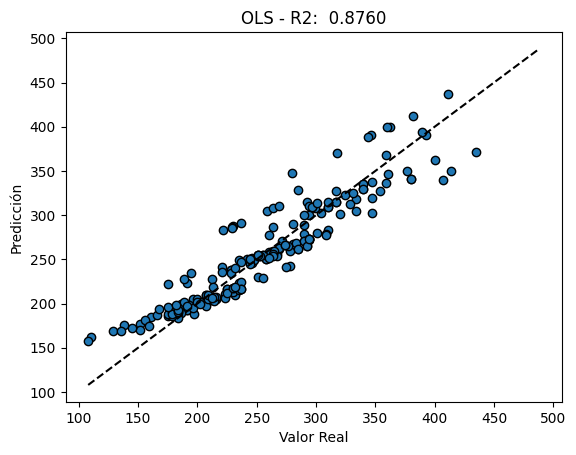

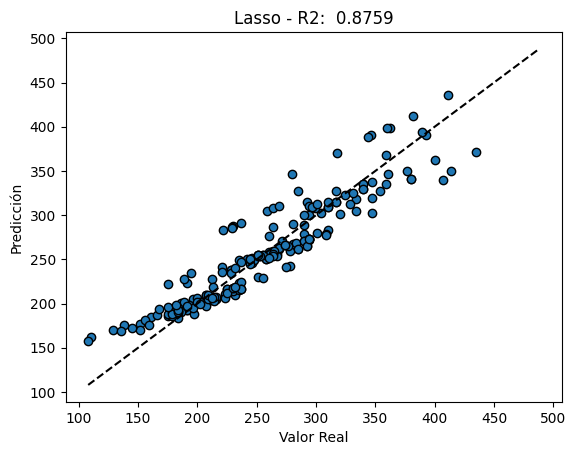

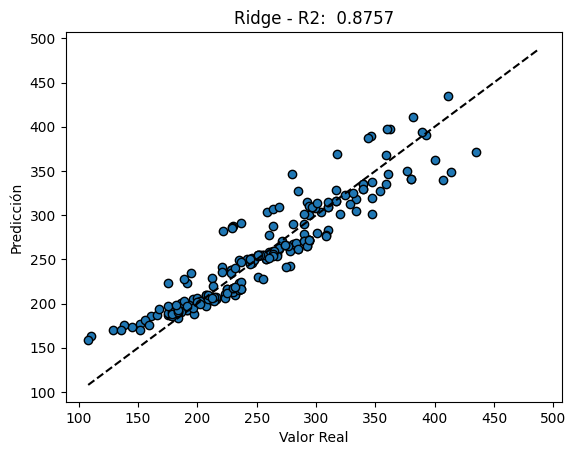

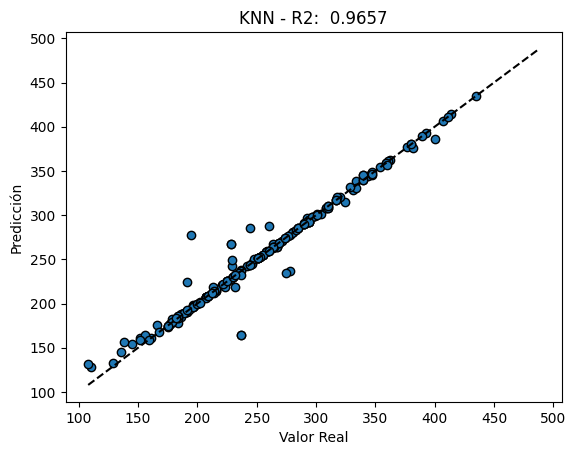

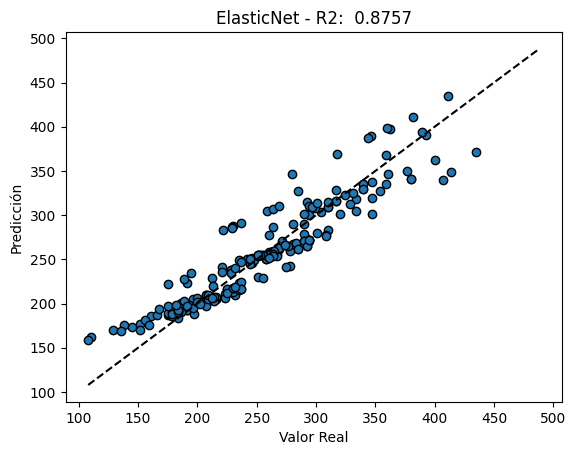

In [59]:
for name in algs.keys():
    fig, ax = plt.subplots() 
    ax.scatter(y_test, y_preds[name], edgecolors=(0, 0, 0))
    ax.set_xlabel('Valor Real')
    ax.set_ylabel('Predicción')
    plt.title(f'{name} - R2: {scores[name]: .4f}')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')


# Clasificación

In [23]:
# Carga de datos

# data = np.load('')
# x = data[:,:-1]
# y = data[:,-1]


# data = pd.read_csv("")
# data.dropna(inplace=True)

# x = np.asarray(data[['','','']])
# y = np.asarray(data[''])


data_clas = load_breast_cancer()
x_clas = data_clas.data
y_clas = data_clas.target

In [24]:
# Separación de datos en entrenamiento y test

x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=42)

# Normalización de datos y estandarización de datos

std_scaling_clas = preprocessing.StandardScaler()

x_train_clas = std_scaling_clas.fit_transform(x_train_clas)
x_test_clas = std_scaling_clas.transform(x_test_clas)

In [25]:
# Comprobamos balanceo de los datos 
ocur_y, frec_y = np.unique(y_clas, return_counts=True)
print('Comprobamos que los datos de test estan balanceados: ', frec_y)

ocur_train, frec_train = np.unique(y_train_clas, return_counts=True)
ocur_test, frec_test = np.unique(y_test_clas, return_counts=True)
print('Train: ', frec_train)
print('Test: ', frec_test)

Comprobamos que los datos de test estan balanceados:  [212 357]
Train:  [169 286]
Test:  [43 71]


In [26]:

# Algoritmos Clasificación
algoritmos_clas = {'SVM': SVC(random_state=42,probability=True), #C, kernel, gamma
              'LOGR': LogisticRegression(random_state=42), #C, solver, penalty
              'DTC': DecisionTreeClassifier(random_state=42) #max_depth
              }

parameters_clas = {'SVM': {'C':(0.01,0.1,0.5,1),
                      'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
                      'gamma':('scale', 'auto')},
              'LOGR': {'C':(0.01,0.1,0.5,1),
                       'max_iter':(50, 100, 200),
                      # 'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'),
                      # 'penalty':('l1', 'l2', None, 'elasticnet')
                      'solver': ('newton-cg', 'lbfgs', 'newton-cholesky', 'liblinear')},
              'DTC': {'max_depth':(5,10,15), 'criterion':('gini', 'entropy')}
              }

# Métricas Clasificación

metricas_clas = {
  'ACC':    metrics.make_scorer(metrics.accuracy_score),
  'PREC':    metrics.make_scorer(lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred,
              average='micro')),
  'RECALL':  metrics.make_scorer(lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred,
              average='micro')),
  'F1':      metrics.make_scorer(lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')),
  'AUC':     metrics.make_scorer(metrics.roc_auc_score, needs_threshold=True)}

In [27]:
# Validación cruzada (Sacando media y desviación estandar de los resultados de cada iteración del KFold)

results = {}
for name in algoritmos_clas.keys():
    results[name] = cross_validate(algoritmos_clas[name], x_train_clas, y_train_clas, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas_clas)

for name, result in results.items():
    print(f'\nAlgorithm {name}')
    for metrica in metricas_clas:
        print(f'{metrica}: {np.mean(result["test_"+metrica]):.4f} +/- {np.std(result["test_"+metrica]):.4f}')
        # print(f'{result["test_"+metrica]}\n')


Algorithm SVM
ACC: 0.9736 +/- 0.0112
PREC: 0.9736 +/- 0.0112
RECALL: 0.9736 +/- 0.0112
F1: 0.9736 +/- 0.0112
AUC: 0.9960 +/- 0.0051

Algorithm LOGR
ACC: 0.9780 +/- 0.0120
PREC: 0.9780 +/- 0.0120
RECALL: 0.9780 +/- 0.0120
F1: 0.9780 +/- 0.0120
AUC: 0.9946 +/- 0.0063

Algorithm DTC
ACC: 0.8857 +/- 0.0204
PREC: 0.8857 +/- 0.0204
RECALL: 0.8857 +/- 0.0204
F1: 0.8857 +/- 0.0204
AUC: 0.8802 +/- 0.0213


In [31]:
# Creación de modelo según hiperparámetros y evaluación de los resultados

y_preds_clas = {}
results_clas = {}

# Guardamos los objetos GridSearchCV en un diccionario, aunque estos no son solo los modelos,
# sino que contienen toda la información, aún así podemos llamarlos como un modelo y siempre 
# utilizara el mejor modelo obtenido en el entrenamiento
model = {}

for name in algoritmos_clas.keys():
  print('Algorithm '+ name)

  score = metricas_clas['F1']
  # GridSearchCV solo utiliza datos del conjunto de entrenamiento, no utiliza datos del conjunto de prueba
  # KFold divide el conjunto de entrenamiento en 5 partes y utiliza 4 para entrenar y 1 para validar
  model_cv = GridSearchCV(algoritmos_clas[name], parameters_clas[name], scoring=score, cv=KFold(n_splits=5, shuffle=True, random_state=42), return_train_score=True)

  model[name] = model_cv.fit(x_train_clas, y_train_clas)

  cv_res = model[name].cv_results_
  best_params = model[name].best_params_
  if best_params:
    print("Best parameters:", best_params)

  best_iter = model[name].best_index_

  # Como GridSearchCV utiliza los datos de entrenamiento los siguientes resultados son sobre los datos de entrenamiento
  print(f'KFold Test F1 Score: {cv_res["mean_test_score"][best_iter]: .4f} +/- {cv_res["std_test_score"][best_iter]: .4f}')
  print(f'KFold Train F1 Score: {cv_res["mean_train_score"][best_iter]: .4f} +/- {cv_res["std_train_score"][best_iter]: .4f}')

  # Para ver que el modelos no se ha sobreajustado, se evalua sobre el conjunto de prueba (datos no utilizados en el entrenamiento)
  #test_score = metrics.accuracy_score(y_test_clas, model[name].predict(x_test_clas))
  test_score = model[name].score(x_test_clas, y_test_clas)
  print(f'Test Accuracy Score: {test_score: .4f}\n')

  # Guardamos las predicciones para cada modelo y las métricas de evaluación
  y_preds_clas[name] = model[name].predict(x_test_clas)
  results_clas[name] = metrics.classification_report(y_test_clas, y_preds_clas[name])

Algorithm SVM
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
KFold Test F1 Score:  0.9780 +/-  0.0139
KFold Train F1 Score:  0.9879 +/-  0.0033
Test Accuracy Score:  0.9561

Algorithm LOGR
Best parameters: {'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}
KFold Test F1 Score:  0.9780 +/-  0.0098
KFold Train F1 Score:  0.9841 +/-  0.0021
Test Accuracy Score:  0.9912

Algorithm DTC
Best parameters: {'criterion': 'entropy', 'max_depth': 5}
KFold Test F1 Score:  0.9187 +/-  0.0204
KFold Train F1 Score:  0.9951 +/-  0.0040
Test Accuracy Score:  0.9474



In [32]:
# Matriz de confusión y AUC

for name in algoritmos_clas.keys():
  print('Algorithm '+ name)
  #print(results_clas[name])
  print(metrics.confusion_matrix(y_test_clas, y_preds_clas[name]))
  
  # Obtener el ACC
  print('Accuracy: ', metrics.accuracy_score(y_test_clas, y_preds_clas[name]), '\n')



Algorithm SVM
[[41  2]
 [ 3 68]]
Accuracy:  0.956140350877193 

Algorithm LOGR
[[42  1]
 [ 0 71]]
Accuracy:  0.9912280701754386 

Algorithm DTC
[[38  5]
 [ 1 70]]
Accuracy:  0.9473684210526315 



Algorithm SVM


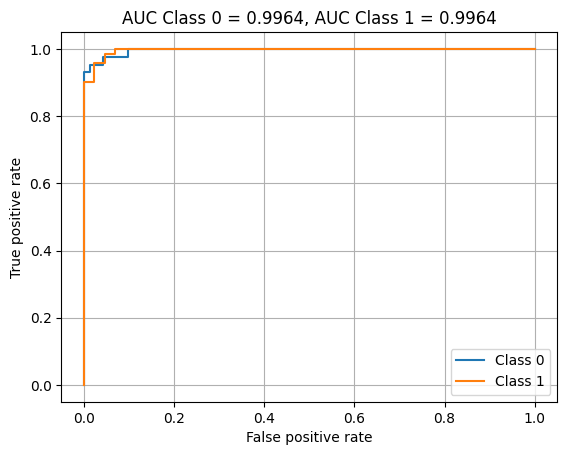

Algorithm LOGR


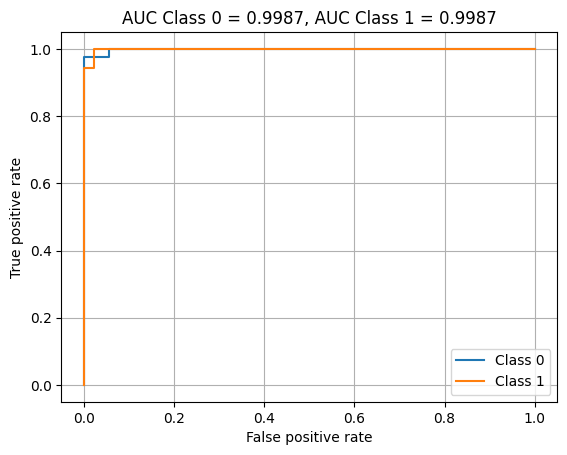

Algorithm DTC


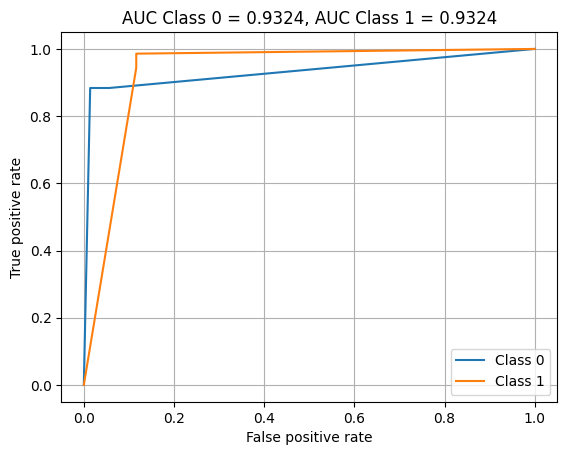

In [33]:
# AUC

for name in algoritmos_clas.keys():
    print('Algorithm '+ name)
    y_proba_test_clas = model[name].predict_proba(x_test_clas) # "predict_proba" para extraer probabilidades en vez de predicciones
    
    # auc = metrics.roc_auc_score(y_test_clas, y_proba_test_clas, multi_class='ovr', average=None) # "multi_class" para clasificación multiclase
    
    # Calculamos el AUC para las dos clases (0 y 1)
    auc_class1 = metrics.roc_auc_score(y_test_clas, y_proba_test_clas[:, 1]) # AUC para una clase en clasificación binaria
    y_testing_neg = np.where(y_test_clas == 0, 1, 0)
    auc_class0 = metrics.roc_auc_score(y_testing_neg, y_proba_test_clas[:, 0]) # AUC para la otra clase en clasificación binaria

    # Curva ROC para la clase 1
    fpr_class1, tpr_class1, th_class1 = metrics.roc_curve(y_test_clas, y_proba_test_clas[:, 1])

    # Curva ROC para la clase 0
    fpr_class0, tpr_class0, th_class0 = metrics.roc_curve(y_testing_neg, y_proba_test_clas[:, 0])

    # Ploteamos ambas curvas ROC
    plt.plot(fpr_class0, tpr_class0, label='Class 0')
    plt.plot(fpr_class1, tpr_class1, label='Class 1')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('AUC Class 0 = ' + str(np.round(auc_class0, 4)) + ', AUC Class 1 = ' + str(np.round(auc_class1, 4)))
    plt.legend()
    plt.grid()
    plt.show()

